In [7]:
import sys
import os
import pandas as pd
import sktime
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

training_dir = os.path.join(os.path.dirname("training/"), '')
sys.path.append(training_dir)
print(training_dir)

training/


       Date  Inventory_Level
0  1/1/2017            29154
1  1/2/2017            55036
2  1/3/2017            83609
3  1/4/2017           105607
4  1/5/2017           143171


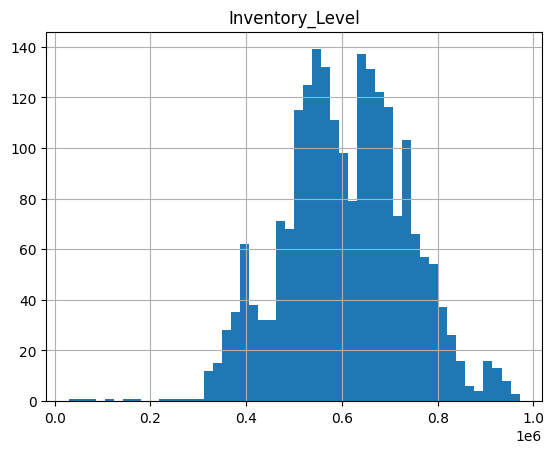

In [5]:
import matplotlib.pyplot as plt
data = pd.read_csv("src/csv/train_inventory(in).csv")
print(data.head())
data.set_index('Date', inplace=True)
data.hist(bins=50)
plt.show()


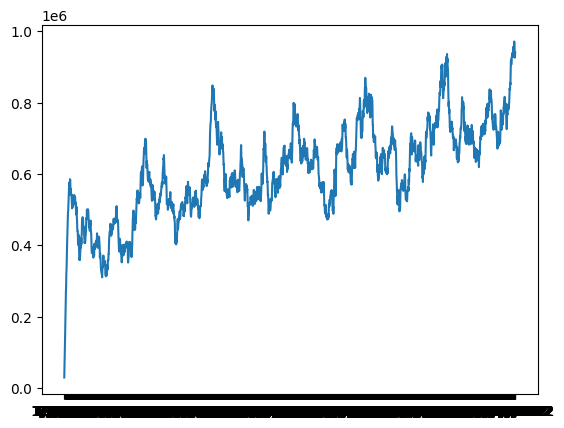

In [6]:
plt.plot(data)

0.1405560248883578


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Inventory_Level'>)

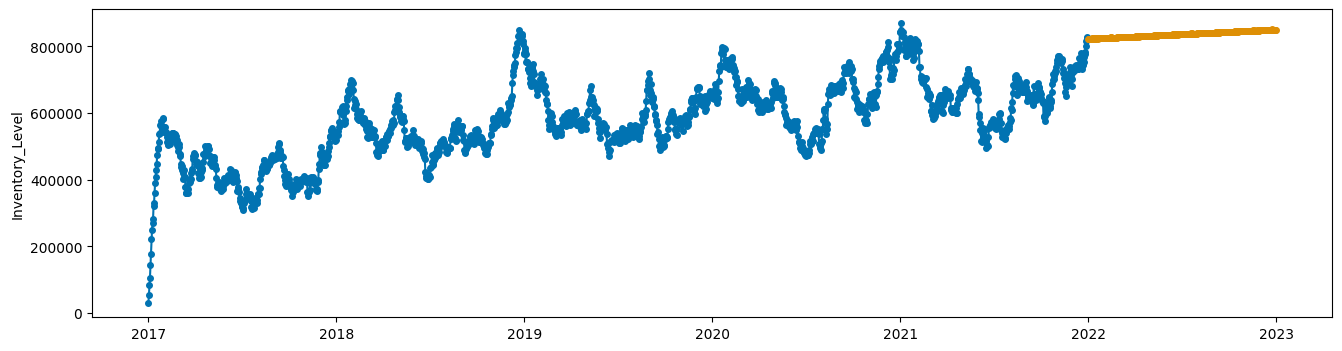

In [16]:
data_inflows = pd.read_csv("src/csv/train_inventory(in).csv", parse_dates=["Date"])

/var/folders/pd/vtwfqsz51lxd0gz80_2mf69c0000gp/T/ipykernel_1738/2877541482.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data_inflows.set_index('Date')['Inventory_Level'].asfreq('M').fillna(0)


                                    Date  Forecasted_Inventory
2023-01-31 2023-01-31 23:59:59.999999999         936504.731642
2023-02-28 2023-02-28 23:59:59.999999999         807678.045200
2023-03-31 2023-03-31 23:59:59.999999999         784575.559661
2023-04-30 2023-04-30 23:59:59.999999999         839454.586595
2023-05-31 2023-05-31 23:59:59.999999999         781434.231223
2023-06-30 2023-06-30 23:59:59.999999999         692400.804954
2023-07-31 2023-07-31 23:59:59.999999999         720963.659975
2023-08-31 2023-08-31 23:59:59.999999999         857903.877049
2023-09-30 2023-09-30 23:59:59.999999999         789902.341137
2023-10-31 2023-10-31 23:59:59.999999999         807083.827969
2023-11-30 2023-11-30 23:59:59.999999999         876998.568653
2023-12-31 2023-12-31 23:59:59.999999999         955260.319341


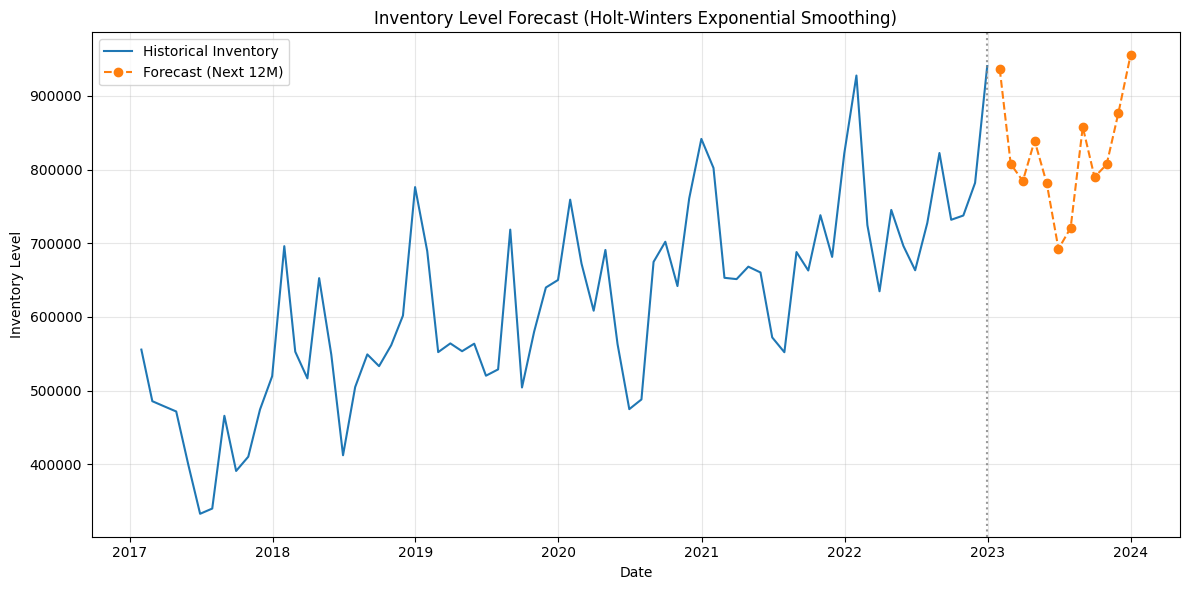

In [28]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Load data
data_inflows = pd.read_csv("src/csv/train_inventory(in).csv", parse_dates=["Date"])

# Use month-end frequency consistently
y = data_inflows.set_index('Date')['Inventory_Level'].asfreq('M').fillna(0)

# Fit model
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
forecaster.fit(y)

# Create a matching forecast horizon (month-end)
last_period = y.index[-1].to_period('M')
fh = ForecastingHorizon(
    pd.period_range(last_period + 1, periods=12, freq='M').to_timestamp(how='end'),
    is_relative=False
)

# Forecast
fcast_vals = forecaster.predict(fh).clip(lower=0)

# Combine into DataFrame
forecast_df = pd.DataFrame({'Date': fh.to_pandas(), 'Forecasted_Inventory': fcast_vals})
print(forecast_df)

fcast_vals = forecaster.predict(fh).clip(lower=0)

forecast_df = pd.DataFrame({
    'Date': fh.to_pandas(),
    'Forecasted_Inventory': fcast_vals
})

# --- 5. Plot historical + forecast
plt.figure(figsize=(12,6))
plt.plot(y.index, y.values, label='Historical Inventory', color='tab:blue')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Inventory'], label='Forecast (Next 12M)', color='tab:orange', linestyle='--', marker='o')

# vertical line separating history from forecast
plt.axvline(x=y.index[-1], color='gray', linestyle=':', alpha=0.8)

plt.title('Inventory Level Forecast (Holt-Winters Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Inventory Level')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
# from sktime.forecasting.base import ForecastingHorizon
# from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# # y is your monthly series (MS frequency). Then:
# forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
# forecaster.fit(y)
# fh = ForecastingHorizon(pd.period_range(y.index[-1].to_period('M')+1, periods=12, freq='M').to_timestamp(), is_relative=False)
# fcast_vals = forecaster.predict(fh).clip(lower=0)


In [26]:
# Re-run using statsmodels' Holt-Winters in place of sktime (environment doesn't have sktime).
import pandas as pd
import numpy as np

# Forecasting (statsmodels)
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
    HW_OK = True
except Exception as e:
    HW_OK = False
    hw_err = str(e)

# Optimization
try:
    import pulp
    PULP_OK = True
except Exception as e:
    PULP_OK = False
    pulp_import_err = str(e)

from caas_jupyter_tools import display_dataframe_to_user

# --------------------
# 1) Load data
# --------------------
outflows = pd.read_csv("/mnt/data/train_outflows(in).csv")
inventory = pd.read_csv("/mnt/data/train_inventory(in).csv")

# Parse dates
outflows['Date'] = pd.to_datetime(outflows['Date'])
inventory['Date'] = pd.to_datetime(inventory['Date'])

# Derive month buckets
outflows['YearMonth'] = outflows['Date'].dt.to_period('M').dt.to_timestamp()
inventory['YearMonth'] = inventory['Date'].dt.to_period('M').dt.to_timestamp()

# --------------------
# 2) Prepare series: monthly Quantity by (Category, Grade)
# --------------------
key_cols = ['Category', 'Grade']
monthly = (
    outflows
    .groupby(key_cols + ['YearMonth'], as_index=False)['Quantity']
    .sum()
    .sort_values(['Category','Grade','YearMonth'])
)

# Compute average EI per (Partner, Category, Grade) (weight by Quantity)
outflows['w_ei'] = outflows['EI_Per_Unit'] * outflows['Quantity']
pcg_ei = (
    outflows
    .groupby(['Partner','Category','Grade'], as_index=False)
    .agg(total_q=('Quantity','sum'), total_ei=('w_ei','sum'))
)
pcg_ei['avg_ei_per_unit'] = pcg_ei['total_ei'] / pcg_ei['total_q']
pcg_ei = pcg_ei.replace([np.inf, -np.inf], np.nan).dropna(subset=['avg_ei_per_unit'])

# Partner monthly min/max bounds from history (total quantity, across all categories/grades)
partner_monthly = outflows.groupby(['Partner','YearMonth'], as_index=False)['Quantity'].sum()
partner_bounds = partner_monthly.groupby('Partner')['Quantity'].agg(['min','max']).reset_index()
partner_bounds.rename(columns={'min':'min_q','max':'max_q'}, inplace=True)

# Fallback min/max bounds if degenerate
p_fallback = partner_monthly.groupby('Partner')['Quantity'].mean().reset_index().rename(columns={'Quantity':'mean_q'})
partner_bounds = partner_bounds.merge(p_fallback, on='Partner', how='left')
partner_bounds['min_q'] = np.where((partner_bounds['min_q']<=0) | partner_bounds['min_q'].isna(), 0.5*partner_bounds['mean_q'], partner_bounds['min_q'])
partner_bounds['max_q'] = np.where((partner_bounds['max_q']<=0) | partner_bounds['max_q'].isna(), 1.5*partner_bounds['mean_q'], partner_bounds['max_q'])

# --------------------
# 3) Forecast next 12 months per (Category, Grade)
# --------------------
h = 12
forecast_rows = []

for (cat, grd), grp in monthly.groupby(['Category','Grade']):
    y = grp.set_index('YearMonth')['Quantity'].asfreq('MS').fillna(0)
    if len(y) < 6 or not HW_OK:
        # fallback: seasonal rolling mean if we have at least 12 obs, else global mean
        if len(y) >= 12:
            baseline = y.rolling(12, min_periods=1).mean().iloc[-1]
        else:
            baseline = y.mean() if len(y)>0 else 0.0
        idx = pd.period_range(y.index[-1].to_period('M')+1, periods=h, freq='M').to_timestamp()
        fcast_vals = pd.Series([baseline]*h, index=idx)
    else:
        try:
            model = HWES(y, trend='add', seasonal='add', seasonal_periods=12, initialization_method="estimated")
            fit = model.fit(optimized=True)
            idx = pd.period_range(y.index[-1].to_period('M')+1, periods=h, freq='M').to_timestamp()
            fcast_vals = pd.Series(fit.forecast(h), index=idx).clip(lower=0)
        except Exception:
            idx = pd.period_range(y.index[-1].to_period('M')+1, periods=h, freq='M').to_timestamp()
            fcast_vals = pd.Series([y.tail(12).mean() if len(y)>0 else 0]*h, index=idx)
    for ts, val in fcast_vals.items():
        forecast_rows.append({'Category': cat, 'Grade': grd, 'YearMonth': ts, 'forecast_qty': float(val)})

forecast_df = pd.DataFrame(forecast_rows).sort_values(['YearMonth','Category','Grade'])

# Show forecast by Category & Grade total for the year
forecast_summary = (forecast_df
                    .groupby(['Category','Grade'], as_index=False)['forecast_qty']
                    .sum()
                    .sort_values('forecast_qty', ascending=False))
display_dataframe_to_user("Next-Year Forecast by Category & Grade (no sktime)", forecast_summary)

# --------------------
# 4) Optimization
# --------------------
partners = sorted(outflows['Partner'].dropna().unique())
cg_list = sorted(monthly[['Category','Grade']].drop_duplicates().itertuples(index=False, name=None))
months = sorted(forecast_df['YearMonth'].unique())

# EI lookups
cg_ei = (
    outflows
    .groupby(['Category','Grade'], as_index=False)
    .agg(total_q=('Quantity','sum'), total_ei=('w_ei','sum'))
)
cg_ei['avg_ei'] = cg_ei['total_ei'] / cg_ei['total_q']
ei_map_cg = {(r['Category'], r['Grade']): r['avg_ei'] for _, r in cg_ei.iterrows()}
ei_map_pcg = {(r['Partner'], r['Category'], r['Grade']): r['avg_ei_per_unit'] for _, r in pcg_ei.iterrows()}

# Bounds map
bounds_map = {r['Partner']: (float(max(0, r['min_q'])), float(max(r['min_q'], r['max_q']))) for _, r in partner_bounds.iterrows()}

# LP or fallback
if not PULP_OK:
    # proportional fallback
    partner_total = partner_monthly.groupby('Partner')['Quantity'].sum()
    total = partner_total.sum()
    share = (partner_total / total).fillna(0)
    alloc_rows = []
    for (c,g), mdf in forecast_df.groupby(['Category','Grade']):
        for m, row in mdf.set_index('YearMonth').iterrows():
            qty = row['forecast_qty']
            for p in partners:
                q_alloc = qty * share.get(p, 0)
                alloc_rows.append({'YearMonth': m, 'Partner': p, 'Category': c, 'Grade': g, 'alloc_qty': float(q_alloc)})
    alloc_df = pd.DataFrame(alloc_rows)
    # Clip to min/max by rescaling within partner-month
    alloc_df = alloc_df.merge(partner_bounds[['Partner','min_q','max_q']], on='Partner', how='left')
    def rescale(group):
        qty = group['alloc_qty'].sum()
        min_q = group['min_q'].iloc[0]
        max_q = group['max_q'].iloc[0]
        if qty == 0:
            return group
        scale = 1.0
        if qty > max_q and max_q > 0:
            scale = max_q / qty
        elif qty < min_q and qty > 0:
            scale = min_q / qty
        group['alloc_qty'] = group['alloc_qty'] * scale
        return group
    alloc_df = alloc_df.groupby(['YearMonth','Partner'], group_keys=False).apply(rescale).reset_index(drop=True)
else:
    # Build and solve LP
    prob = pulp.LpProblem("EI_Maximization", pulp.LpMaximize)
    X = {}
    for p in partners:
        for (c,g) in cg_list:
            for m in months:
                vname = f"x__{abs(hash(p))%10000}_{abs(hash(c))%10000}_{abs(hash(g))%10000}_{m.strftime('%Y%m')}"
                X[(p,c,g,m)] = pulp.LpVariable(vname, lowBound=0, cat="Continuous")
    # Objective
    prob += pulp.lpSum(X[(p,c,g,m)] * float(ei_map_pcg.get((p,c,g), ei_map_cg.get((c,g), 0.0)))
                       for p in partners for (c,g) in cg_list for m in months)
    # Supply constraints
    fcast_lookup = {(r.Category, r.Grade, pd.Timestamp(r.YearMonth)): r.forecast_qty for r in forecast_df.itertuples()}
    for (c,g) in cg_list:
        for m in months:
            qty = float(fcast_lookup.get((c,g,m), 0.0))
            prob += pulp.lpSum(X[(p,c,g,m)] for p in partners) == qty
    # Partner bounds per month
    for p in partners:
        pmin, pmax = bounds_map.get(p, (0.0, 1e9))
        for m in months:
            prob += pulp.lpSum(X[(p,c,g,m)] for (c,g) in cg_list) >= float(pmin)
            prob += pulp.lpSum(X[(p,c,g,m)] for (c,g) in cg_list) <= float(pmax)
    # Solve
    _ = prob.solve(pulp.PULP_CBC_CMD(msg=False))
    # Extract solution
    rows = []
    for (p,c,g,m), var in X.items():
        val = var.value() if hasattr(var, "value") else pulp.value(var)
        if val is None:
            val = 0.0
        rows.append({'YearMonth': m, 'Partner': p, 'Category': c, 'Grade': g, 'alloc_qty': float(val)})
    alloc_df = pd.DataFrame(rows)

# --------------------
# 5) Outputs
# --------------------
forecast_csv_path = "/mnt/data/next_year_forecast_by_cat_grade_no_sktime.csv"
forecast_df.to_csv(forecast_csv_path, index=False)

def lookup_ei(row):
    return float(ei_map_pcg.get((row['Partner'], row['Category'], row['Grade']), ei_map_cg.get((row['Category'], row['Grade']), 0.0)))
alloc_df['ei_per_unit_used'] = alloc_df.apply(lookup_ei, axis=1)
alloc_df['est_total_ei'] = alloc_df['alloc_qty'] * alloc_df['ei_per_unit_used']

alloc_csv_path = "/mnt/data/allocation_plan.csv"
alloc_df.to_csv(alloc_csv_path, index=False)

# Summaries
alloc_summary_pm = (alloc_df.groupby(['YearMonth','Partner'], as_index=False)
                    .agg(alloc_qty=('alloc_qty','sum'), est_total_ei=('est_total_ei','sum'))
                    .sort_values(['YearMonth','Partner']))
alloc_summary_cg = (alloc_df.groupby(['YearMonth','Category','Grade'], as_index=False)
                    .agg(alloc_qty=('alloc_qty','sum'), est_total_ei=('est_total_ei','sum'))
                    .sort_values(['YearMonth','Category','Grade']))

display_dataframe_to_user("Forecast (downloadable file available below)", forecast_df.head(200))
display_dataframe_to_user("Allocation — Partner x Month (qty & est EI)", alloc_summary_pm.head(200))
display_dataframe_to_user("Allocation — Category/Grade x Month (qty & est EI)", alloc_summary_cg.head(200))
display_dataframe_to_user("Partner monthly min/max constraints (derived from history)", partner_bounds)

forecast_csv_path, alloc_csv_path


ModuleNotFoundError: No module named 'caas_jupyter_tools'